In [1]:
add_gsw = false
build_packages = false

if build_packages
    using Pkg
    Pkg.build("IJulia")
    Pkg.build("NetCDF")
end

dir = "../pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT

if add_gsw
    using Conda
    Conda.add("gsw")
end
gsw = pyimport("gsw");

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 200;

In [2]:
N = sqrt(1.5)*1.e-3
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

dt = 2.e-5
dt_recip = Int(round(dt^-1))

topo_col = (0.75,0.75,0.80);

PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;

In [172]:
dir = "../pgcm/"
expname = "ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))

nIter = dt_recip*50

nf = 50
del = 3

figure(figsize=(16,8))

short_name = L"$\hat{\delta} = 0.4$"

#------------------------  Load 3d Model data  ------------------------------

m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(size(s.bc))
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(size(s.bc))
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(size(s.bc))
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(size(s.bc))
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Buoyancy tendency
s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
dbdt = (s1.bc .- s.bc) ./ (m.dt*5000.)

# Diagnose exact diffusive flux divergence as residual of other explicit terms
Dk = dbdt .- (Du .+ Dr)

# Explicit vertical flux divergence
hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
Dkz = zeros(size(s.bc))
Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);
sim_full_ridge_mask = (yc.>=0.) .& (xc.>0.25) .& (xc.<0.75);

x_fy,y_fy = 
[m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
[m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);
sim_full_ridge_mask_yf = (y_fy.>=0.) .& (x_fy.>0.25) .& (x_fy.<0.75);

###############    Water mass transformation     ##################
mins = -1.1
dsf = round(abs(mins/nf),digits=5)
sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

zc_basin = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_basin[i] = sum(idx.*sf.*m.hfy.*(m.yf.>=0))./sum(idx.*(m.yf.>=0))
end
zc_basin[isnan.(zc_basin)] .= -1.

zc_full = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc_full[i] = sum(idx.*sf.*m.hfy.*sim_full_ridge_mask_yf)./sum(idx.*sim_full_ridge_mask_yf)
end
zc_full[isnan.(zc_full)] .= -1.

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
end
zc[isnan.(zc)] .= -1.

########################################
zref = vcat(copy(zc),[0])
zref_basin = vcat(copy(zc_basin),[0])
zref_full = vcat(copy(zc_full),[0])

bref_f = vcat(copy(bf)[:,1,1])
bref = vcat(copy(bc)[:,1,1])
nref = length(bref)
intD = zeros(size(bref))

BBLmask = Dk.>0.
for i=1:m.nx
    for j=1:m.ny
        BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
    end
end


In [173]:
Dk_mean = zeros(size(bref))
Dk_mean_Nsqb = zeros(size(bref))
Dk_mean_kb = zeros(size(bref))

k_mean = zeros(size(bref))
Nsq_mean = zeros(size(bref))

kz_mean = zeros(size(bref))
Nsqz_mean = zeros(size(bref))

dV = (m.hc*m.ds)*m.dx*m.dy .* ones(size(Dk))

kc = zeros(size(dV))
kc[2:end-1,:,:] = (m.kfs[1:end-1,:,:] .+ m.kfs[2:end,:,:]) / 2.

Nsq = dscc(m,s.bc,0) ./m.hc

for i=1:1:nref
    idx = (bref_f[i] .<= s.bc) .& (s.bc .<= bref_f[i+1]) .& sim_ridge_mask
    
    Nsq_mean[i] = sum( (Nsq .*dV)[idx]) / sum(dV[idx])
    k_mean[i] = sum( (kc .*dV)[idx]) / sum(dV[idx])
    
    Nsqz_mean[i] = sum( (dscc(m, Nsq, 0) ./m.hc .*dV)[idx]) / sum(dV[idx])
    kz_mean[i] = sum( (dscc(m, kc, 0) ./m.hc .*dV)[idx]) / sum(dV[idx])
end

tmp = diff(k_mean .* Nsq_mean)./diff(bref)
Dk_mean[2:end-1] = (tmp[1:end-1] .+ tmp[2:end])/2.

tmp = diff(Nsq_mean)./diff(bref)
Dk_mean_Nsqb[2:end-1] = k_mean[2:end-1] .* ((tmp[1:end-1] .+ tmp[2:end])/2.)

tmp = diff(k_mean)./diff(bref)
Dk_mean_kb[2:end-1] = Nsq_mean[2:end-1] .* ((tmp[1:end-1] .+ tmp[2:end])/2.)

48-element Array{Float64,1}:
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
 NaN                    
   ⋮                    
   0.004075084432478797 
  -0.0025566770668102295
  -0.006374152492659146 
  -0.008705837941603284 
  -0.0027617810073087847
   0.0072318109433417216
   0.024788947778466415 
   0.056459616150603936 
  -0.013126496994331681 
  -0.1366824011480769   
  -0.1308163200683631   
  -0.07922116698200389  

In [174]:
intD = zeros(size(bref))
intD_mean = zeros(size(bref))
intD_res = zeros(size(bref))

intD_Nsqb = zeros(size(bref))
intD_kb = zeros(size(bref))

for i=1:1:nref
    idx = (s.bc .<= bref[i]) .& sim_ridge_mask
    intD[i] = sum((Dk.*dV)[idx])
    intD_mean[i] = sum(Dk_mean[i]*dV[idx])
    intD_res[i] = sum((Dk.*dV)[idx]) - sum(Dk_mean[i]*dV[idx])
    
    intD_Nsqb[i] = sum(Dk_mean_Nsqb[i]*dV[idx])
    intD_kb[i] = sum(Dk_mean_kb[i]*dV[idx])
end
T = diff(intD)./diff(bref) #*Tscale
T[isnan.(T)] .= 0;

T_mean = diff(intD_mean)./diff(bref) #*Tscale
T_res = diff(intD_res)./diff(bref) #*Tscale

T_Nsqz = diff(intD_Nsqb)./diff(bref) #*Tscale
T_kz = diff(intD_kb)./diff(bref) #*Tscale


49-element Array{Float64,1}:
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  ⋮                   
 -0.011503026217246113
 -0.011454549172678078
 -0.01056047193685858 
  0.01717670521260309 
  0.038842089254168384
  0.08157893933320844 
  0.16813769172061055 
 -0.3468346632943501  
 -0.7382738840030109  
 -0.020888181768583397
  0.3028812428891856  
  0.5111858538307255  

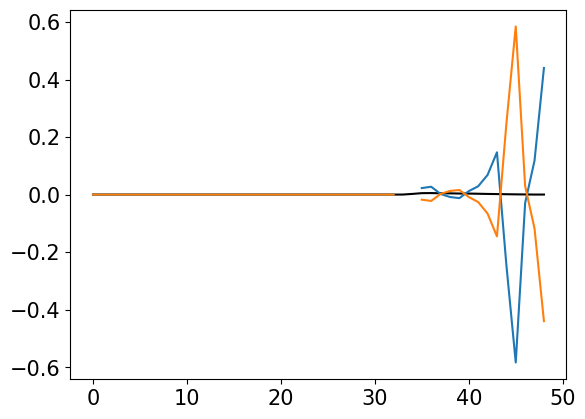

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff43a738128>

In [176]:

plot(T, "k-")
plot(T_mean, "C0-")
plot(T_res, "C1-")
#plot(T_Nsqz, "k--")
#plot(T_kz, "k:")
#plot(T_kz+T_Nsqz, "k--")
#ylim([-0.01, 0.01])

In [ ]:
labels = [
L"Total$^{(z)}$",
L"1",
L"1"
]

flux_list = [
Dk,
Dkz_mean,
Dkz_res,
]

mask_list = [
trues(size(Dk)),
trues(size(Dk)),
trues(size(Dk))
]

colors = [
"k",
"C0",
"C1",
]

linestyles = [
"-",
"-",
"-",
];